In [5]:

import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()


In [6]:
df = spark.sql('''select 'spark' as hello ''')
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



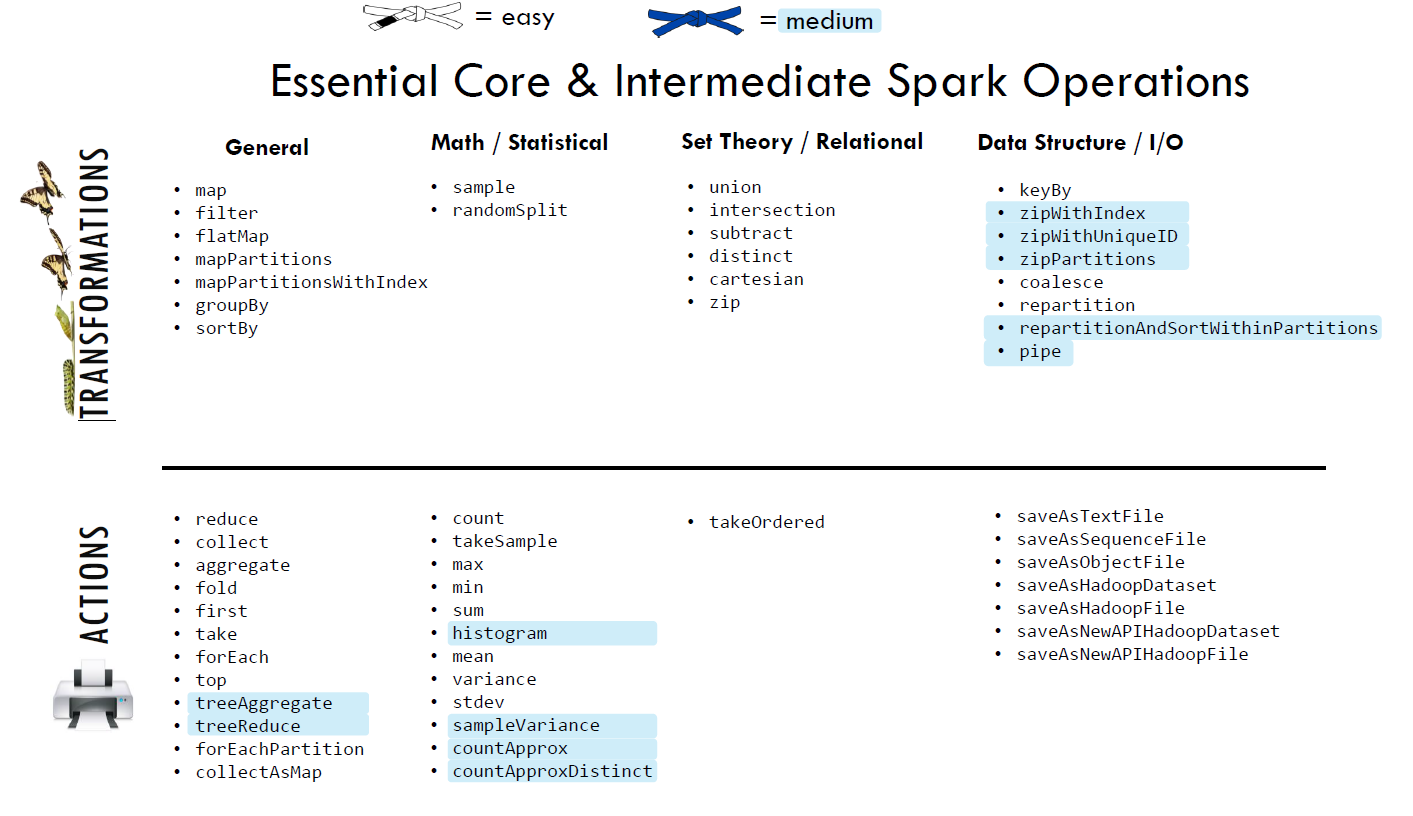

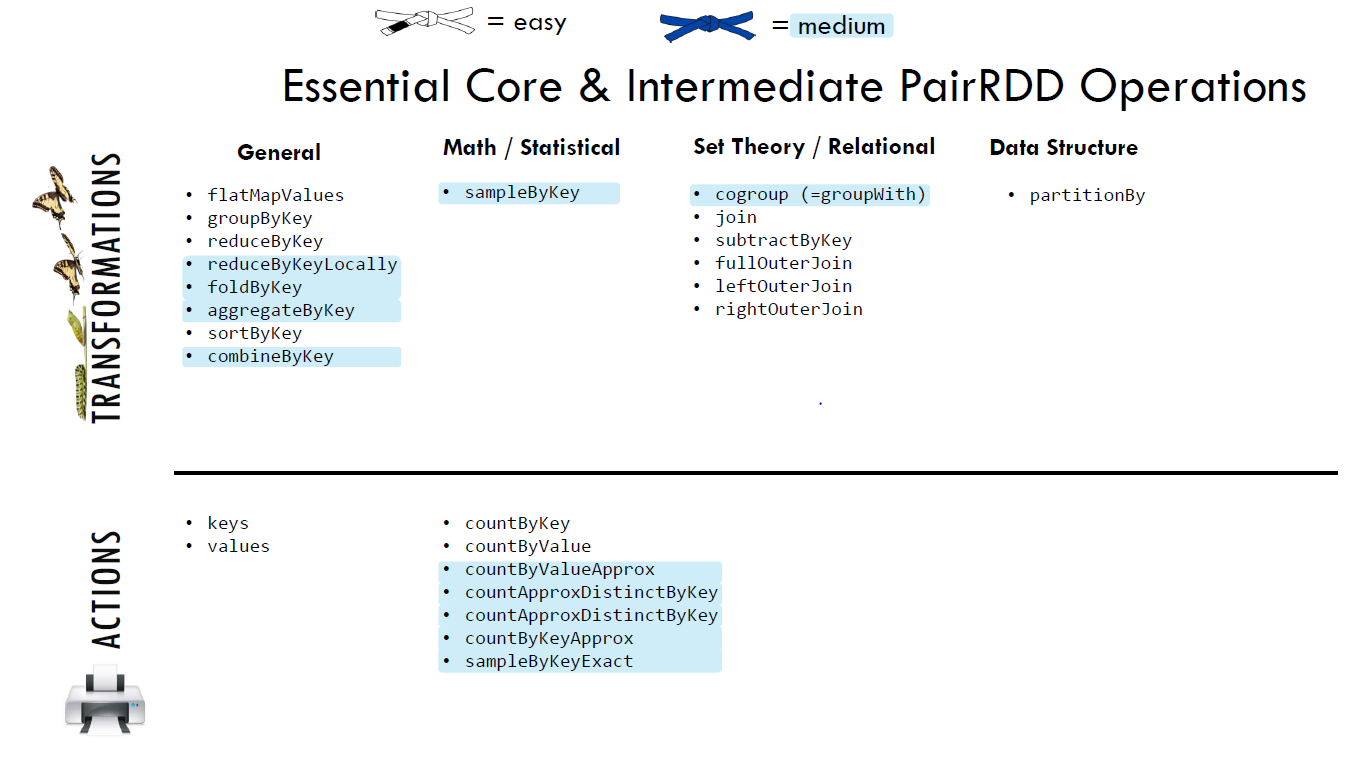

Lineage :- 

“One of the challenges in providing RDDs as an abstraction is choosing a representation for them that can track lineage across a wide range of transformations.”

“The most interesting question in designing this interface is how to represent dependencies between RDDs.”

“We found it both sufficient and useful to classify dependencies into two types:

•narrow dependencies, where each partition of the parent RDD is used by at most one partition of the child RDD

•wide dependencies, where multiple child partitions may depend on it.”

In [7]:
# creating pyspark context
from pyspark import SparkConf
from pyspark import SparkContext
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

In [8]:
# map := Return a new RDD by applying a function to each element of this RDD
# map(f, preservesPartitioning=False)
x= sc.parallelize( ["b", "a", "c"])  
y= x.map(lambda z: (z, 1))
print(x.collect())
print(y.collect())

['b', 'a', 'c']
[('b', 1), ('a', 1), ('c', 1)]


In [9]:
# filter := Return a new RDD containing only the elements that satisfy a predicate
#filter(f)

x= sc.parallelize([1,2,3])
y= x.filter(lambda x: x%2 == 1) #keep odd values
print(x.collect())
print(y.collect())


[1, 2, 3]
[1, 3]


In [10]:
# flatemap :=> Return a new RDD by first applying a function to all elements of this RDD, and then flattening the results
# flatMap(f, preservesPartitioning=False)

x= sc.parallelize([1,2,3])
y= x.flatMap(lambda x: (x, x*100, 42))
print(x.collect())
print(y.collect())

[1, 2, 3]
[1, 100, 42, 2, 200, 42, 3, 300, 42]


In [11]:
# GroupBy :=> Group the data in the original RDD. Create pairs where the key is the output of a user function, and the value is all items for which the function yields this key.
#groupBy(f, numPartitions=None) 

x= sc.parallelize(['John', 'Fred', 'Anna', 'James'])
y= x.groupBy(lambda w: w[0])
print( [(k, list(v)) for (k, v) in y.collect()]  )


[('F', ['Fred']), ('J', ['John', 'James']), ('A', ['Anna'])]


In [12]:
# groupByKey :=> Group the values for each key in the original RDD. Create a new pair where the original key corresponds to this collected group of values.
# groupByKey(numPartitions=None)

x= sc.parallelize([('B',5),('B',4),('A',3),('A',2),('A',1)])
y= x.groupByKey()
print(x.collect())
print(list((j[0], list(j[1])) for j in y.collect()))

[('B', 5), ('B', 4), ('A', 3), ('A', 2), ('A', 1)]
[('B', [5, 4]), ('A', [3, 2, 1])]


In [13]:
# REDUCEBYKEYVSGROUPBYKEY

words = ("one", "two", "two", "three", "three", "three")

wordPairsRDD= sc.parallelize(words).map( lambda word :(word, 1))

wordCountsWithReduce= wordPairsRDD.reduceByKey(lambda a,b: a+b).collect()

wordCountsWithGroup = wordPairsRDD.groupByKey().mapValues(len).collect()

wordCountsWithGroup

[('two', 2), ('three', 3), ('one', 1)]

In [14]:
# MAPPARTITIONS :=> Return a new RDD by applying a function to each partition of this RDD
#mapPartitions(f, preservesPartitioning=False)

x= sc.parallelize([1,2,3], 2)
def f(iterator):yield sum(iterator); yield 42
y= x.mapPartitions(f)
# glom() flattens elements on the same partition
print(x.glom().collect())
print(y.glom().collect())

[[1], [2, 3]]
[[1, 42], [5, 42]]


In [15]:
#MAPPARTITIONSWITHINDEX :=> Return a new RDD by applying a function to each partition of this RDD, while tracking the index of the original partition
# mapPartitionsWithIndex(f, preservesPartitioning=False)

x= sc.parallelize([1,2,3], 2)
def f(partitionIndex, iterator):yield (partitionIndex, sum(iterator))
y= x.mapPartitionsWithIndex(f)
# glom() flattens elements on the same partition
print(x.glom().collect())
print(y.glom().collect())



[[1], [2, 3]]
[[(0, 1)], [(1, 5)]]


In [16]:
# SAMPLE :=> Return a new RDD containing a statistical sample of the original RDD
# sample(withReplacement, fraction, seed=None)

x= sc.parallelize([1, 2, 3, 4, 5])
y= x.sample(False, 0.4, 4)
print(x.collect())
print(y.collect())


[1, 2, 3, 4, 5]
[1, 5]


In [17]:
# UNION :=> Return a new RDD containing all items from two original RDDs. Duplicates are not culled.
# union(otherRDD)

x= sc.parallelize([1,2,3], 2)
y= sc.parallelize([3,4], 1)
z= x.union(y)
print(z.glom().collect())

[[1], [2, 3], [3, 4]]


In [18]:
# JOIN :=> Return a new RDD containing all pairs of elements having the same key in the original RDDs
# union(otherRDD, numPartitions=None)
x= sc.parallelize([("a", 1), ("b", 2)])
y= sc.parallelize([("a", 3), ("a", 4), ("b", 5)])
z= x.join(y)
print(z.collect())


[('b', (2, 5)), ('a', (1, 3)), ('a', (1, 4))]


In [19]:
# DISTINCT :=> Return a new RDD containing distinct items from the original RDD (omitting all duplicates)
# distinct(numPartitions=None)

x= sc.parallelize([1,2,3,3,4])
y= x.distinct()
print(y.collect())

[1, 2, 3, 4]


In [20]:
# COALESCE :=> Return a new RDD which is reduced to a smaller number of partitions
# coalesce(numPartitions, shuffle=False)

x = sc.parallelize([1, 2, 3, 4, 5], 3)
y= x.coalesce(2)
print(x.glom().collect())
print(y.glom().collect())

[[1], [2, 3], [4, 5]]
[[1], [2, 3, 4, 5]]


In [21]:
 # KEYBY : => Create a Pair RDD, forming one pair for each item in the original RDD. The pair’s key is calculated from the value via a user-supplied function.
    
x= sc.parallelize(['John', 'Fred', 'Anna', 'James'])
y= x.keyBy(lambda w: w[0])
print (y.collect() )

[('J', 'John'), ('F', 'Fred'), ('A', 'Anna'), ('J', 'James')]


In [24]:
# PARTITIONBY => Return a new RDD with the specified number of partitions, placing original items into the partition returned by a user supplied function

# partitionBy(numPartitions, partitioner=portable_hash)

x = sc.parallelize([('J','James'),('F','Fred'),('A','Anna'),('J','John')], 3)
y= x.partitionBy(2, lambda w: 0 if w[0] < 'H' else 1)
print (x.glom().collect() )
print (y.glom().collect()  )


[[('J', 'James')], [('F', 'Fred')], [('A', 'Anna'), ('J', 'John')]]
[[('F', 'Fred'), ('A', 'Anna')], [('J', 'James'), ('J', 'John')]]


In [25]:
# ZIP :=> Return a new RDD containing pairs whose key is the item in the original RDD, and whose value is that item’s corresponding element (same partition, same index) in a second RDD
# zip(otherRDD)

x= sc.parallelize([1, 2, 3])
y= x.map(lambda n:n*n)
z= x.zip(y)
print(z.collect())

[(1, 1), (2, 4), (3, 9)]


In [27]:
# GETNUMPARTITIONS : => Return the number of partitions in RDD //getNumPartitions()

x= sc.parallelize([1,2,3], 2)
y= x.getNumPartitions()
print(x.glom().collect())
print(y)

[[1], [2, 3]]
2


In [28]:
# COLLECT :=> Return all items in the RDD to the driver in a single list //collect()

x= sc.parallelize([1,2,3], 2)
y= x.collect()
print(x.glom().collect())
print(y)

[[1], [2, 3]]
[1, 2, 3]


In [29]:
# REDUCE :=> reduce(f) => Aggregate all the elements of the RDD by applying a user function pairwise to elements and partial results, and returns a result to the driver

x = sc.parallelize([1,2,3,4])
y= x.reduce(lambda a,b: a+b)
print(x.collect())
print(y)

[1, 2, 3, 4]
10


In [30]:
'''# AGGREGATE :=> aggregate(identity, seqOp, combOp) => Aggregate all the elements of the RDD by:
-applying a user function to combine elements with user-supplied objects,
-then combining those user-defined results via a second user function,
-and finally returning a result to the driver.
'''

seqOp= lambda data, item: (data[0] + [item], data[1] + item)
combOp= lambda d1, d2: (d1[0] + d2[0], d1[1] + d2[1])
x= sc.parallelize([1,2,3,4])
y= x.aggregate(([], 0), seqOp, combOp)
print(y)

([1, 2, 3, 4], 10)


In [31]:
# MAX :=> max() => Return the maximum item in the RDD

x= sc.parallelize([2,4,1])
y= x.max()
print(x.collect())
print(y)

[2, 4, 1]
4


In [32]:
# SUM :=> sum() => Return the sum of the items in the RDD

x= sc.parallelize([2,4,1])
y= x.sum()
print(x.collect())
print(y)

[2, 4, 1]
7


In [33]:
# MEAN :=> mean() => Return the mean of the items in the RDD 

x= sc.parallelize([2,4,1])
y= x.mean()
print(x.collect())
print(y)


[2, 4, 1]
2.3333333333333335


In [34]:
# STDEV :=> stdev() => Return the standard deviation of the items in the RDD

x= sc.parallelize([2,4,1])
y= x.stdev()
print(x.collect())
print(y)

[2, 4, 1]
1.247219128924647


In [35]:
# COUNTBYKEY :=> countByKey() // Return a map of keys and counts of their occurrences in the RDD

x = sc.parallelize([('J', 'James'), ('F','Fred'),
('A','Anna'), ('J','John')])
y= x.countByKey()
print(y)

defaultdict(<class 'int'>, {'J': 2, 'F': 1, 'A': 1})


In [44]:
# SAVEASTEXTFILE :=> saveAsTextFile(path,compressionCodecClass=None) //Save the RDD to the filesystemindicated in the path

x= sc.parallelize([2,4,1])
x.saveAsTextFile("file:\\C:\\Users\\dev30\\OneDrive\\Documents\\GitHub\\Pyspark\\demo")
y= sc.textFile("file:\\C:\\Users\\dev30\\OneDrive\\Documents\\GitHub\\Pyspark\\demo")
print(y.collect())

['2', '4', '1']


In [39]:
pwd

'C:\\Users\\dev30\\OneDrive\\Documents\\GitHub\\Pyspark'